## Extended DDM brief analysis

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import data_reader
import matplotlib.patches as mpatches
import os
import matplotlib.lines as mlines
###################################
%matplotlib inline
mpl.matplotlib_fname();

### First, read the data exported from the matlab script

In [3]:
csv_path = '../output/csv/'
# csv files variables- for better readability:
eDDM_pcom= pd.read_csv(os.path.join(csv_path, 'eDDM_pcom.txt'), sep=',')
eDDM_psychometric = pd.read_csv(os.path.join(csv_path, 'eDDM_psychometric.txt'), sep=',')
eDDM_psychometric_CoM= pd.read_csv(os.path.join(csv_path, 'eDDM_psychometric_CoM.txt'), sep=',')
eDDM_response_times = pd.read_csv(os.path.join(csv_path, 'eDDM_response_times.txt'), sep=',')
eDDM_tertiles = pd.read_csv(os.path.join(csv_path, 'eDDM_tertiles.txt'), sep=',')

eDDM_stim_off_tertiles = pd.read_csv(os.path.join(csv_path, 'eDDM_stim_off_tertiles.txt'), sep=',')
eDDM_stim_off_pcom = pd.read_csv(os.path.join(csv_path, 'eDDM_stim_off_pcom.txt'), sep=',')

### Set this to a custom path if you want to save figs elsewhere

In [4]:
global save_path
save_path= '../output/figures'

## First, the validation that the simulation actually works.

### Try and reproduce : (a) P(CoM) vs. Coherence (b) Response time vs. Coherence for subject S. 

In [56]:
def plot_eDDM_rt(eDDM_response_times):
    global save_path
    local_save_path = save_path
    plt.figure()
    fig, ax = plt.subplots(ncols=1)
    
    ax.errorbar(x=range(5), y=eDDM_response_times.init_times[1::], yerr=eDDM_response_times.init_times_sem[1::],
                 ls='-', fmt='-s',color='black', label='Correct', marker='o', lw=3, ms=8)
     
    ax.set_xlabel('Coherence')
    ax.set_ylabel('Response time (ms)')
    ax.set_xticks(range(5))
    ax.set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))
    plt.tight_layout()
    plt.savefig(os.path.join(local_save_path, 'eDDM_rts.png'), bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

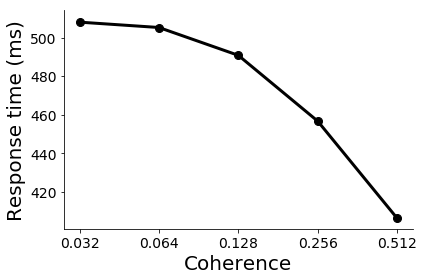

In [94]:
plot_eDDM_rt(eDDM_response_times)

In [6]:
def plot_eDDM_p_com(eDDM_pcom, filename):
    global save_path
    local_save_path = save_path
    plt.figure()
    fig, ax = plt.subplots(ncols=1)
    
    ax.plot(range(6), eDDM_pcom.p_com_correct, marker = 'o', color='black', label='correct',ls='-')
    ax.plot(range(6), eDDM_pcom.pcom_incorrect, marker = 'o',color='grey', label='error',ls='-')
    
    ax.set_xlabel('Coherence')
    ax.set_ylabel('Probability of CoM')
    ax.legend()

    ax.set_xticklabels(('0.0', '0.032', '0.064', '0.128', '0.256', '0.512'))
    ax.set_ylim(-0.005, 0.22)
    plt.tight_layout()
    plt.savefig(os.path.join(local_save_path, filename), bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

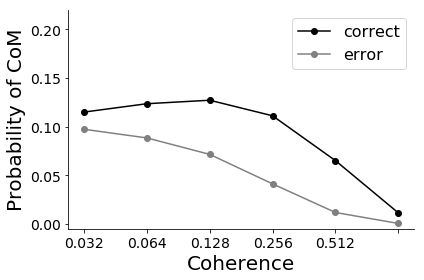

In [7]:
filename = 'eDDM_pcom.png'
plot_eDDM_p_com(eDDM_pcom, filename)

## Second, we calculate the unreported result: P(CoM) vs Coherence split by response time


In [25]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).apply(len)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(data, var, filename, palette='viridis_r', n_threshold=0, ax=None):
    global save_path
    local_save_path = save_path
    ci = get_ci_vs_var(data, var, n_threshold=n_threshold)

    ax = sns.pointplot(data=ci, x='coherence', y='p_com', hue=var, palette=palette, ax=ax)
    
    ax.set_ylabel('p(CoM)')

    ax.set_xlabel('Coherence')
    ax.set_ylim(-0.005, 0.15)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True, title=var, title_fontsize='large')
    plt.savefig(os.path.join(local_save_path, filename), bbox_inches='tight')
    return ax

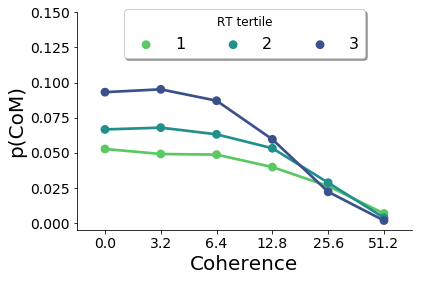

In [26]:
filename = 'eDDM_tertiles.png'
eDDM_tertiles['RT tertile'] = pd.qcut(eDDM_tertiles['hand_IT'], 3, labels=[1, 2,3])
eDDM_tertiles['is_com'] = eDDM_tertiles['is_com'].astype('bool')

fig, axes = plt.subplots(ncols=1)
plot_p_com_vs_var_ci(eDDM_tertiles, 'RT tertile', filename, n_threshold=10, ax=axes)

## Finally, we repeat the same P(CoM) results above with stimulus switched off upon 1st threshold crossing.

<Figure size 432x288 with 0 Axes>

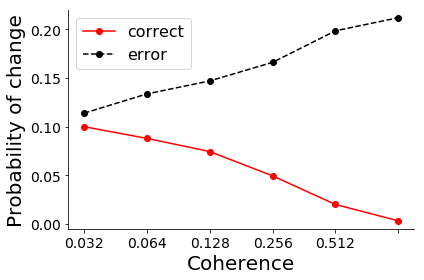

In [86]:
filename = 'eDDM_stim_off_pcom.png'
plot_eDDM_p_com(eDDM_stim_off_pcom, filename)

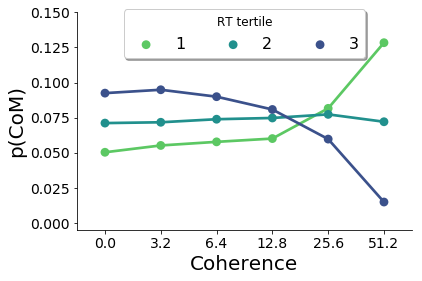

In [27]:
filename = 'eDDM_stim_off_tertiles.png'
eDDM_stim_off_tertiles['RT tertile'] = pd.qcut(eDDM_stim_off_tertiles['hand_IT'], 3, labels=[1, 2,3])
eDDM_stim_off_tertiles['is_com'] = eDDM_stim_off_tertiles['is_com'].astype('bool')

fig, axes = plt.subplots(ncols=1)
plot_p_com_vs_var_ci(eDDM_stim_off_tertiles, 'RT tertile', filename, n_threshold=10, ax=axes)